## Parity Plot

Combine individual parity plots into one large figure containing all parity plots for every operator

In [ ]:
import pathlib

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
from plot_methods import get_parity_data, make_parity_plot

#TODO clean up this entire notebook
cm_1_data, cm_1_notes = get_parity_data('Carbon Mapper', stage = 1)
cm_2_data, cm_2_notes = get_parity_data('Carbon Mapper', stage = 2)
cm_3_data, cm_3_notes = get_parity_data('Carbon Mapper', stage = 3)
ghg_1_data, ghg_1_notes = get_parity_data('GHGSat-AV', stage = 1)
ghg_2_data, ghg_2_notes = get_parity_data('GHGSat-AV', stage = 2)
ghg_3_data, ghg_3_notes = get_parity_data('GHGSat-AV', stage = 3)
kairos_1_data, kairos_1_notes = get_parity_data('Kairos', stage=1)
kairos_2_data, kairos_2_notes = get_parity_data('Kairos', stage=2)
kairos_3_data, kairos_3_notes = get_parity_data('Kairos', stage=3)
mair_1_data, mair_1_notes = get_parity_data('Methane Air', stage=1)
sciav_1_data, sciav_1_notes = get_parity_data('Scientific Aviation', stage=1, strict_discard=True)

fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])

# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.05, hspace=0.18)  # Modify the values as needed

# Set axes
axes_max = 2300
# Carbon Mapper
ax1 = make_parity_plot(cm_1_data, cm_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot(cm_2_data, cm_2_notes, ax2, [0, axes_max])
ax3 = make_parity_plot(cm_3_data, cm_3_notes, ax3, [0, axes_max])

print('Making GHGSat plots...')
# GHGSat
ax4 = make_parity_plot(ghg_1_data, ghg_1_notes, ax4, [0, axes_max])
ax5 = make_parity_plot(ghg_2_data, ghg_2_notes, ax5, [0, axes_max])
ax6 = make_parity_plot(ghg_3_data, ghg_3_notes, ax6, [0, axes_max])

print('Making Kairos plots...')
# Kairos
ax7 = make_parity_plot(kairos_1_data, kairos_1_notes, ax7, [0, axes_max])
ax8 = make_parity_plot(kairos_2_data, kairos_2_notes, ax8, [0, axes_max])
ax9 = make_parity_plot(kairos_3_data, kairos_3_notes, ax9, [0, axes_max])

# MethaneAIR
print('Making MethaneAIR plots...')

ax10 = make_parity_plot(mair_1_data, mair_1_notes, ax10, [0, axes_max])

# Scientific Aviation
ax11 = make_parity_plot(sciav_1_data, sciav_1_notes, ax11, [0, axes_max])

# Turn off last axes
ax12.axis('off')

######## Figure Annotations ########

# # Add a large horizontal line above the bottom row
# line = Line2D([0.08, 0.94], [0.29, 0.29], color='black', transform=fig.transFigure, linewidth=3)
# fig.add_artist(line)

# Add common x-axis
txt_x_label = fig.text(0.5, 0.08, 'Release Rate (kg / hr)', ha='center', va='bottom', fontsize=20)

# Add common y-axis
txt_y_label_left = fig.text(0.08, 0.4, 'Operator Quantification Estimate (kg / hr)', rotation = 'vertical', ha='center', va='bottom', fontsize=20)


# Save figure
now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_parity_{save_time}')
plt.savefig(save_path)
print('Figure saved')

Making GHGSat plots...
Making Kairos plots...
Making MethaneAIR plots...
Figure saved


In [ ]:
# Figure of all residuals
from plot_methods import plot_residuals
import matplotlib.pyplot as plt
import datetime
import pathlib

residual_ylim = [-400, 900]
residual_xlim = [0, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])
above_mdl = False

ax1 = plot_residuals(ax1, above_mdl, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_residuals(ax2, above_mdl, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_residuals(ax3, above_mdl, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_residuals(ax4, above_mdl, residual_xlim, residual_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_residuals(ax5, above_mdl,  residual_xlim, residual_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_residuals(ax6, above_mdl, residual_xlim, residual_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_residuals(ax7, above_mdl, residual_xlim, residual_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_residuals(ax8, above_mdl, residual_xlim, residual_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_residuals(ax9, above_mdl, residual_xlim, residual_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_residuals(ax10, above_mdl, residual_xlim, residual_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_residuals(ax11, above_mdl, residual_xlim, residual_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all', strict_discard=True)

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_residuals_all_{save_time}')
plt.savefig(save_path)
print('Figure saved!!!')


In [ ]:
# Figure of all residual percent error
from plot_methods import plot_residual_percent_error
import matplotlib.pyplot as plt
import datetime
import pathlib

residual_ylim = [-300, 300]
residual_xlim = [0, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])
above_mdl = False

ax1 = plot_residual_percent_error(ax1, above_mdl, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax1.set
ax2= plot_residual_percent_error(ax2, above_mdl, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_residual_percent_error(ax3, above_mdl, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_residual_percent_error(ax4, above_mdl, residual_xlim, residual_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_residual_percent_error(ax5, above_mdl,  residual_xlim, residual_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_residual_percent_error(ax6, above_mdl, residual_xlim, residual_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_residual_percent_error(ax7, above_mdl, residual_xlim, residual_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_residual_percent_error(ax8, above_mdl, residual_xlim, residual_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_residual_percent_error(ax9, above_mdl, residual_xlim, residual_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_residual_percent_error(ax10, above_mdl, residual_xlim, residual_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_residual_percent_error(ax11, above_mdl, residual_xlim, residual_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all', strict_discard=True)

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_residuals_percent_error_{save_time}')
plt.savefig(save_path)
print('Figure saved!!!')


In [ ]:
# Figure of all absolute error
from plot_methods import plot_quant_error_absolute
import matplotlib.pyplot as plt
import datetime
import pathlib

absolute_ylim = [-500, 1200]
absolute_xlim = [0, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])
above_mdl = False


ax1 = plot_quant_error_absolute(ax1, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_quant_error_absolute(ax2, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_quant_error_absolute(ax3, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_quant_error_absolute(ax4, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_quant_error_absolute(ax5, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_quant_error_absolute(ax6, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_quant_error_absolute(ax7, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_quant_error_absolute(ax8, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_quant_error_absolute(ax9, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_quant_error_absolute(ax10, above_mdl, absolute_xlim, absolute_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_quant_error_absolute(ax11, above_mdl, absolute_xlim, absolute_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all', strict_discard=True)

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_error_absolute_{save_time}')
plt.savefig(save_path)
print('Figure saved')

In [ ]:
# Figure of percent error for all releases included in parity plot of the main text
from plot_methods import plot_quant_error_percent
import matplotlib.pyplot as plt
import datetime
import pathlib

absolute_ylim = [-700, 750]
absolute_xlim = [0, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])
above_mdl = False

ax1 = plot_quant_error_percent(ax1, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_quant_error_percent(ax2, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_quant_error_percent(ax3, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_quant_error_percent(ax4, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_quant_error_percent(ax5, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_quant_error_percent(ax6, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_quant_error_percent(ax7, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_quant_error_percent(ax8, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_quant_error_percent(ax9, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_quant_error_percent(ax10, above_mdl, absolute_xlim, absolute_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_quant_error_percent(ax11, above_mdl, absolute_xlim, absolute_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all', strict_discard=True)

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_error_percent_all_{save_time}')
plt.savefig(save_path)
print('Figure saved')

In [ ]:
# Figure of percent error for releases under 50 kgh
from plot_methods import plot_quant_error_percent
import matplotlib.pyplot as plt
import datetime
import pathlib

absolute_ylim = [-700, 750]
absolute_xlim = [0, 50]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])
above_mdl = False

ax1 = plot_quant_error_percent(ax1, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_quant_error_percent(ax2, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_quant_error_percent(ax3, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_quant_error_percent(ax4, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_quant_error_percent(ax5, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_quant_error_percent(ax6, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_quant_error_percent(ax7, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_quant_error_percent(ax8, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_quant_error_percent(ax9, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_quant_error_percent(ax10, above_mdl, absolute_xlim, absolute_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_quant_error_percent(ax11, above_mdl, absolute_xlim, absolute_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all', strict_discard=True)

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_error_percent_under50kgh_{save_time}')
plt.savefig(save_path)
print('Figure saved')

In [ ]:
# Figure with percent error above 50 kgh
from plot_methods import plot_quant_error_percent
import matplotlib.pyplot as plt
import datetime
import pathlib

absolute_ylim = [-300, 300]
absolute_xlim = [50, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])
above_mdl = False

ax1 = plot_quant_error_percent(ax1, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_quant_error_percent(ax2, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_quant_error_percent(ax3, above_mdl, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_quant_error_percent(ax4, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_quant_error_percent(ax5, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_quant_error_percent(ax6, above_mdl, absolute_xlim, absolute_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_quant_error_percent(ax7, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_quant_error_percent(ax8, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_quant_error_percent(ax9, above_mdl, absolute_xlim, absolute_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_quant_error_percent(ax10, above_mdl, absolute_xlim, absolute_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_quant_error_percent(ax11, above_mdl, absolute_xlim, absolute_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all', strict_discard=True)

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_error_percent_above50kgh_{save_time}')
plt.savefig(save_path)
print('Figure saved')

/Users/sea/PycharmProjects/CRF22_Airplanes/plot_methods.py:365: RuntimeWarning: invalid value encountered in scalar divide
  p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows
/Users/sea/PycharmProjects/CRF22_Airplanes/plot_methods.py:365: RuntimeWarning: invalid value encountered in scalar divide
  p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows


Figure saved
Figure saved


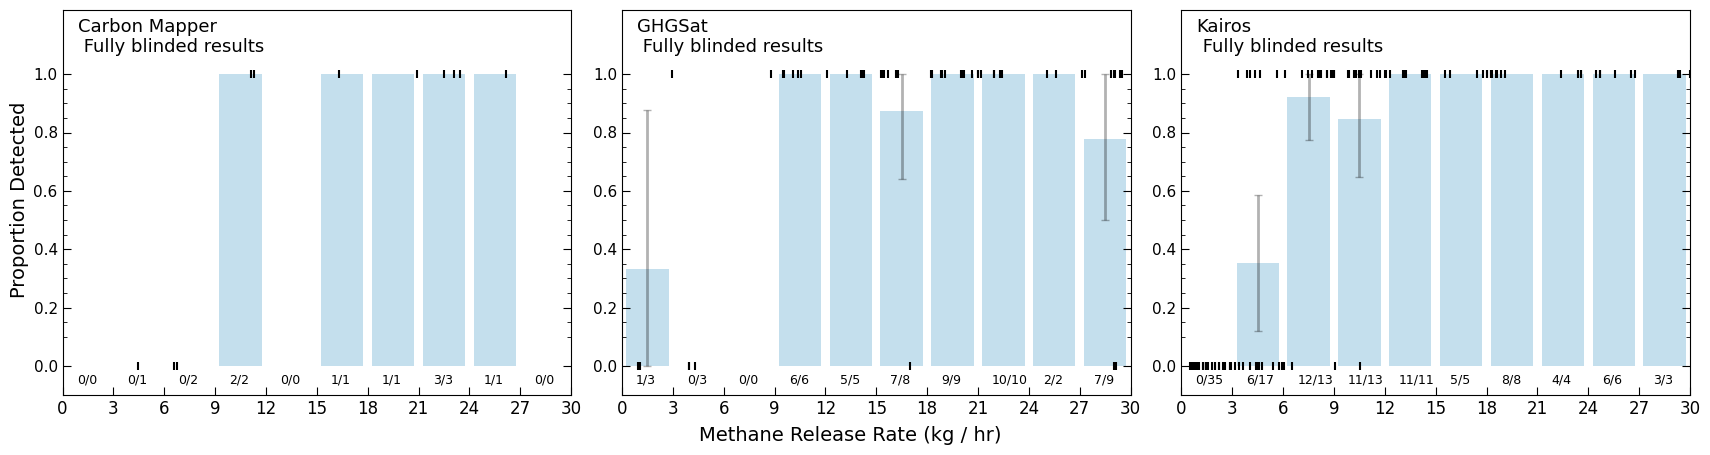

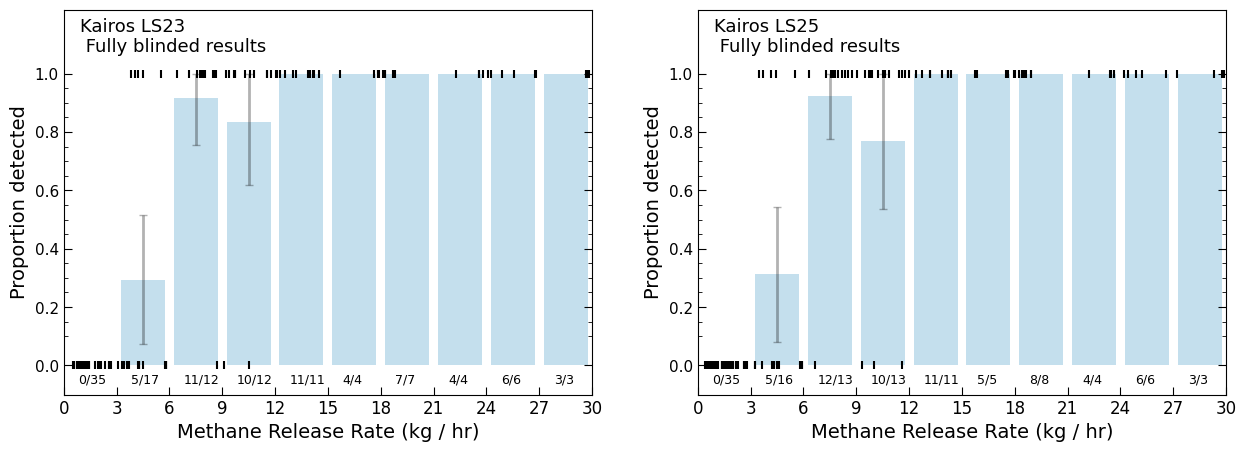

In [1]:
# Make combined plot with lower detection limit

# %% Function: plot_detection_limit
from plot_methods import plot_detection_limit, plot_logistic_regression

import datetime
import pathlib


# inputs:
# operator: name of operator
# operator_report: operator data report
# operator_meter: operator meter data
# n_bins: number of bins desired in plot
# threshold: highest release rate in kgh to show in detection threshold graph


import matplotlib.pyplot as plt
from plot_methods import get_parity_data, make_parity_plot


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=[21, 5])

# Set probability of detection plot parameters
bins = 10
threshold = 30
ax1 = plot_detection_limit(ax1, operator='Carbon Mapper', stage=1, n_bins=bins, threshold=threshold, strict_discard=False, time_ave=60, gas_comp_source='ms')

ax2 = plot_detection_limit(ax2, operator='GHGSat', stage=1, n_bins=bins, threshold=threshold, strict_discard=False, time_ave=60, gas_comp_source='ms')
# ax2 = plot_logistic_regression(ax2, threshold=threshold, operator='GHGSat', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')

ax3 = plot_detection_limit(ax3, operator='Kairos', stage=1, n_bins=bins, threshold=threshold, strict_discard=False, time_ave=60, gas_comp_source='ms')
# ax3 = plot_logistic_regression(ax3, threshold=threshold, operator='Kairos', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
for ax in [ax1, ax2, ax3]:
    ax.set(xlabel='', ylabel='')
# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1)

# Annotate main y-axis and x-axis
# Common y-axis
fig.text(0.5, 0.01, 'Methane Release Rate (kg / hr)', ha='center', va='bottom', fontsize=14)
fig.text(0.1, 0.5, 'Proportion Detected', ha='left', va='center', rotation='vertical', fontsize=14)



# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_detection_prob_{save_time}')
plt.savefig(save_path)
print('Figure saved')


fig2, [ax1, ax2] = plt.subplots(1, 2, figsize=[15, 5])

# Set probability of detection plot parameters
bins = 10
threshold = 30
ax1 = plot_detection_limit(ax1, operator='Kairos LS23', stage=1, n_bins=bins, threshold=threshold, strict_discard=False, time_ave=60, gas_comp_source='ms')

ax2 = plot_detection_limit(ax2, operator='Kairos LS25', stage=1, n_bins=bins, threshold=threshold, strict_discard=False, time_ave=60, gas_comp_source='ms')

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'kairos_detection_prob_{save_time}')
plt.savefig(save_path)
print('Figure saved')

In [ ]:
import math
from methods_source import abbreviate_op_name
from matplotlib.patches import Patch
import numpy as np

def make_releases_histogram_subplot(ax1, ax2, ax3, operator, stage, strict_discard=False, time_ave=60, gas_comp_source='ms'):
    """

    :param ax1: subplot for displaying zero releases
    :param ax2: subplot for displaying mid-range (0 to 50 kgh)
    :param ax3: subplot for displaying high range (50 to 1600 kgh)
    :param operator: name of operator
    :param stage: stage of anlaysis (1, 2, 3)
    :param strict_discard: Boolean, False is default value
    :param time_ave: time average period for meter data (60s is default)
    :param gas_comp_source: source for gas compositional analysis, default value is measurement station ('ms')
    :return ax1: subplot with zero releases
    :return ax2: subplot with mid-range releases
    :return ax3: subplot with high range releases
    """
    ############## Setup Data ##############

    # Create bins for middle histogram plot
    threshold_lower = 0
    threshold_upper = 50
    n_bins = 10
    op_histogram_low = classify_histogram_data(operator=operator, stage=stage,
                                               threshold_lower=threshold_lower, threshold_upper=threshold_upper,
                                               n_bins=n_bins,
                                               strict_discard=strict_discard, time_ave=time_ave,
                                               gas_comp_source=gas_comp_source)

    # Create bins for right histogram plot
    threshold_lower = 50
    threshold_upper = 1500
    n_bins = 30
    op_histogram_high = classify_histogram_data(operator=operator, stage=stage,
                                                threshold_lower=threshold_lower, threshold_upper=threshold_upper,
                                                n_bins=n_bins,
                                                strict_discard=strict_discard, time_ave=time_ave,
                                                gas_comp_source=gas_comp_source)

    ############## Figure ##############
    # fig, [ax1, ax2, ax3] = plt.subplots(1, 3,
    #                                     figsize=(10, 3),
    #                                     gridspec_kw={'width_ratios': [0.6, 3, 4]})

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.05,
                        hspace=0.05)

    # Determine max value for the y-axis
    # low_height = op_histogram_low.bin_height.max()
    # high_height = op_histogram_high.bin_height.max()
    # y_height = max(low_height, high_height)
    # y_height = math.ceil(y_height / 5) * 5

    # Hard code desired bin height for each operator
    op_ab = abbreviate_op_name(operator)
    bin_height_dict = {
        'cm': 50,
        'ghg': 50,
        'kairos': 50,
        'mair':5,
        'sciav':5,

    }
    y_height = bin_height_dict[op_ab]
    # Manually set y_height
    #y_height = 50

    # Ram's colors:
    seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
    #           0sangre,    1neptune,  2pumpkin,  3clover,  4denim,     5cocoa,     6cumin  7berry

    # Color scheme
    tp_color = seshadri[3]
    tn_color = seshadri[1]
    fp_color = seshadri[2]
    fn_color = seshadri[0]
    su_color = seshadri[4]
    op_color = seshadri[5]
    missing_color = seshadri[6]

    ####### Left histogram #######
    bar_width = 0.2
    # add true negatives
    ax1.bar(0, op_histogram_low.true_negative, width=bar_width, edgecolor='black', color=tn_color)

    # Zero release discarded by SU
    # su_filter_height0 = op_histogram_low.true_negative
    # ax1.bar(0, op_histogram_low.zero_filter_su, bottom=su_filter_height0, width=bar_width, label='Stanford Filtered',
    #         edgecolor='black', color=su_color)


    # Zero release discarded by operator
    op_filter_height0 = op_histogram_low.true_negative
    ax1.bar(0, op_histogram_low.zero_filter_op, bottom=op_filter_height0, width=bar_width, label='Operator Filtered',
            edgecolor='black', color=op_color)

    # Missing data zero release
    missing_height = np.add(op_filter_height0, op_histogram_low.zero_filter_op).tolist()
    ax1.bar(0, op_histogram_low.zero_missing, bottom=missing_height, width=bar_width, label='Missing',
            edgecolor='black', color=missing_color)

    # Add false positives
    false_positive_height = np.add(missing_height, op_histogram_low.zero_missing).tolist()
    ax1.bar(0, op_histogram_low.false_positive, bottom=false_positive_height, width=bar_width, label='False Positive',
            edgecolor='black', color=fp_color)

    ####### Middle histogram #######
    bar_width = 4.2
    # Middle plot

    # Add True Positives
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.true_positive, width=bar_width,
            label='True positive', edgecolor='black', color=tp_color)

    # Add False Positives
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.false_positive, bottom=op_histogram_low.true_positive,
            width=bar_width, label='False positive', edgecolor='black', color=fp_color)

    # Add False Negatives
    fn_height = np.add(op_histogram_low.true_positive, op_histogram_low.false_positive).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.false_negative, bottom=op_histogram_low.true_positive,
            width=bar_width, label='False Negative', edgecolor='black', color=fn_color)

    # Add Stanford QC
    # su_filter_height = np.add(fn_height, op_histogram_low.false_negative).tolist()
    # ax2.bar(op_histogram_low.bin_median, op_histogram_low.filter_stanford, bottom=su_filter_height, width=bar_width,
    #         label='Stanford Filtered', edgecolor='black', color=su_color)
    # su_filter_height = 0

    # Add Carbon Mapper QC
    op_filter_height = np.add(fn_height, op_histogram_low.false_negative).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.filter_operator, bottom=op_filter_height, width=bar_width,
            label='Operator Filtered', edgecolor='black', color=op_color)

    # Add missing data
    missing_height = np.add(op_filter_height, op_histogram_low.filter_operator).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.missing_data, bottom=missing_height, width=bar_width,
            label='Missing', edgecolor='black', color=missing_color)

    ####### Right plot #######

    # reset bin width
    bar_width = 40
    # Add True Positives
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.true_positive, width=bar_width, label='True positive',
            edgecolor='black', color=tp_color)

    # Add False Positives
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.false_positive, bottom=op_histogram_high.true_positive,
            width=bar_width, label='False positive', edgecolor='black', color=fp_color)

    # Add False Negatives
    fn_height = np.add(op_histogram_high.true_positive, op_histogram_high.false_positive).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.false_negative, bottom=op_histogram_high.true_positive,
            width=bar_width, label='False Negative', edgecolor='black', color=fn_color)

    # Add Stanford QC
    # su_filter_height = np.add(fn_height, op_histogram_high.false_negative).tolist()
    # ax3.bar(op_histogram_high.bin_median, op_histogram_high.filter_stanford, bottom=su_filter_height, width=bar_width,
    #         label='Stanford Filtered', edgecolor='black', color=su_color)

    # Add Carbon Mapper QC
    op_filter_height = np.add(fn_height, op_histogram_high.false_negative).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.filter_operator, bottom=op_filter_height, width=bar_width,
            label='Operator Filtered', edgecolor='black', color=op_color)

    # Add missing data
    missing_height = np.add(op_filter_height, op_histogram_high.filter_operator).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.missing_data, bottom=missing_height, width=bar_width,
            label='Missing', edgecolor='black', color=missing_color)

    ############ Plot formatting ############
    # Set height of x and y axis limits
    # Left plot only shows zero
    ax1.set_ylim(bottom=0, top=y_height)
    ax1.set_xlim([-0.25, 0.25])

    # Middle plot shows >0 to 50 kgh
    ax2.set_ylim(bottom=0, top=y_height)
    ax2.set_xlim(left=-0.5, right=51)

    # Right plot shows 50 to 1500
    ax3.set_ylim(bottom=0, top=y_height)
    ax3.set_xlim(left=30, right=1500)

    # Common label for x-axis on all suplots
    # txt_x_label = fig.text(0.5, -0.08, 'Release Rate (kgh)', ha='center', va='bottom', fontsize=14)

    # Plot title
    # remove stage for methane air
    #txt_title = fig.text(0.5, 1, f'{operator} Results Classification', ha='center', va='top', fontsize=15)

    # Axes formatting and labels
    ax1.set_xticks([0])  # only have a tick at 0
    ax1.set_ylabel('Number of Releases', fontsize=12)
    ax1.tick_params(labelsize=12)
    ax1.minorticks_on()
    ax1.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)  # only label left & bottom axis
    ax1.tick_params(direction='in', which='major', axis='y', length=4, left=True, right=True)  # y-axis major
    # Turn off minor axis ticks for SciAv plot
    ax1.tick_params(direction='in', which='minor', length=2, left=True, right=True)  # y-axis minor
    ax1.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major

    # Format axes on middle plot
    ax2.tick_params(labelsize=12)
    ax2.minorticks_on()
    ax2.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=False)  # only label bottom axis
    ax2.tick_params(direction='in', which='major', axis='y', length=4, left=True, right=True)  # y-axis major

    # Turn off minor axis ticks for SciAv plot
    ax2.tick_params(direction='in', which='minor', length=2, left=True, right=True)  # y-axis minor
    ax2.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major
    ax2.tick_params(which='minor', axis='x', bottom=False, top=False)
    x_ticks = ax2.xaxis.get_major_ticks()
    x_ticks[1].label1.set_visible(False)  # remove label on x=0
    x_ticks[1].set_visible(False)

    # Format axes on right plot
    ax3.tick_params(labelsize=12)
    ax3.minorticks_on()
    ax3.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=False)  # only label on bottom
    ax3.tick_params(axis='y', which='major', direction='in', length=4, left=True, right=True)  # y-axis major
    # Turn off minor axis ticks for SciAv plot
    ax3.tick_params(axis='y', which='minor', direction='in', length=2, left=True, right=True)  # y-axis minor

    ax3.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major
    ax3.tick_params(which='minor', axis='x', bottom=False, top=False)

    # Set axes and background color to white
    ax1.set_facecolor('white')
    ax1.spines['top'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['right'].set_color('black')
    ax1.spines['bottom'].set_color('black')

    return ax1, ax2, ax3


# fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21,28])

fig, [[ax1, ax2, ax3],[ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12], [ax13, ax14, ax15]] = plt.subplots(5, 3, figsize=(10, 16), gridspec_kw={'width_ratios': [0.6, 3, 4]})

ax1, ax2, ax3 = make_releases_histogram_subplot(ax1, ax2, ax3, operator='Carbon Mapper', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')

ax4, ax5, ax6 = make_releases_histogram_subplot(ax4, ax5, ax6, operator='GHGSat', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax7, ax7, ax9 = make_releases_histogram_subplot(ax7, ax8, ax9, operator='Kairos', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax10, ax11, ax12 = make_releases_histogram_subplot(ax10, ax11, ax12, operator='MethaneAIR', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax13, ax14, ax15 = make_releases_histogram_subplot(ax13, ax14, ax15, operator='Scientific Aviation', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.35)
# Add legend

seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']

# Color scheme
tp_color = seshadri[3]
tn_color = seshadri[1]
fp_color = seshadri[2]
fn_color = seshadri[0]
su_color = seshadri[4]
op_color = seshadri[5]
missing_color = seshadri[6]

histogram_legend = {
    'True Positive': tp_color,
    'True Negative': tn_color,
    'False Positive': fp_color,
    'False Negative': fn_color,
    # 'Stanford Filtered': su_color,
    'Operator Filtered': op_color, # remove operator filter for Methane AIR
    'Missing data': missing_color,
}

legend_elements = [Patch(facecolor=v, edgecolor='black', label=k) for k, v in histogram_legend.items()]
# lgd = ax3.legend(title='Overpass Key', handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
lgd = ax3.legend(title='Overpass Key', handles=legend_elements, loc='upper right', fontsize=9)

# Turn off minor ticks for MAIR and SciAV
small_scale_ax = [ax10, ax11, ax12, ax13, ax14, ax15]
for ax in small_scale_ax:
    ax.tick_params(axis='y', which='minor', direction='in', length=2, left=False, right=False)

# Add common x-axis
txt_x_label = fig.text(0.5, 0.065, 'Release Rate (kgh)', ha='center', va='bottom', fontsize=14)

# Add text for each opertor
left_align = 0.1
font_size = 10
cm_label = fig.text(left_align, 0.904, 'Carbon Mapper results classification\n(fully blinded)', fontsize=font_size, style='italic')
ghg_label = fig.text(left_align, 0.736, 'GHGSat results classification\n(fully blinded)', fontsize=font_size, style='italic')
kairos_label = fig.text(left_align, 0.568, 'Kairos results classification\n(fully blinded)', fontsize=font_size, style='italic')
mair_label = fig.text(left_align, 0.399, 'MethaneAIR results classification\n(fully blinded)', fontsize=font_size, style='italic')
sciav_label = fig.text(left_align, 0.231, 'Scientific Aviation results classification\n(fully blinded)', fontsize=font_size, style='italic')

# Save Figure
now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_histograms_vertical_{save_time}')
plt.savefig(save_path)
print('Figure saved')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from methods_source import classify_histogram_data, abbreviate_op_name
from matplotlib.patches import Patch
import datetime
import pathlib

def make_releases_histogram_subplot(ax1, ax2, ax3, operator, stage, strict_discard=False, time_ave=60, gas_comp_source='ms'):
    """

    :param ax1: subplot for displaying zero releases
    :param ax2: subplot for displaying mid-range (0 to 50 kgh)
    :param ax3: subplot for displaying high range (50 to 1600 kgh)
    :param operator: name of operator
    :param stage: stage of anlaysis (1, 2, 3)
    :param strict_discard: Boolean, False is default value
    :param time_ave: time average period for meter data (60s is default)
    :param gas_comp_source: source for gas compositional analysis, default value is measurement station ('ms')
    :return ax1: subplot with zero releases
    :return ax2: subplot with mid-range releases
    :return ax3: subplot with high range releases
    """
    ############## Setup Data ##############

    # Create bins for middle histogram plot
    threshold_lower = 0
    threshold_upper = 50
    n_bins = 10
    op_histogram_low = classify_histogram_data(operator=operator, stage=stage,
                                               threshold_lower=threshold_lower, threshold_upper=threshold_upper,
                                               n_bins=n_bins,
                                               strict_discard=strict_discard, time_ave=time_ave,
                                               gas_comp_source=gas_comp_source)

    # Create bins for right histogram plot
    threshold_lower = 50
    threshold_upper = 1500
    n_bins = 30
    op_histogram_high = classify_histogram_data(operator=operator, stage=stage,
                                                threshold_lower=threshold_lower, threshold_upper=threshold_upper,
                                                n_bins=n_bins,
                                                strict_discard=strict_discard, time_ave=time_ave,
                                                gas_comp_source=gas_comp_source)

    ############## Figure ##############
    # fig, [ax1, ax2, ax3] = plt.subplots(1, 3,
    #                                     figsize=(10, 3),
    #                                     gridspec_kw={'width_ratios': [0.6, 3, 4]})

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.05,
                        hspace=0.05)

    # Determine max value for the y-axis
    # low_height = op_histogram_low.bin_height.max()
    # high_height = op_histogram_high.bin_height.max()
    # y_height = max(low_height, high_height)
    # y_height = math.ceil(y_height / 5) * 5

    # Hard code desired bin height for each operator
    op_ab = abbreviate_op_name(operator)
    bin_height_dict = {
        'cm': 50,
        'ghg': 50,
        'kairos': 50,
        'mair':5,
        'sciav':5,

    }
    y_height = bin_height_dict[op_ab]
    # Manually set y_height
    #y_height = 50

    # Ram's colors:
    seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
    #           0sangre,    1neptune,  2pumpkin,  3clover,  4denim,     5cocoa,     6cumin  7berry

    # Color scheme
    tp_color = seshadri[3]
    tn_color = seshadri[1]
    fp_color = seshadri[2]
    fn_color = seshadri[0]
    su_color = seshadri[4]
    op_color = seshadri[5]
    missing_color = seshadri[6]

    ####### Left histogram #######
    bar_width = 0.2
    # add true negatives
    ax1.bar(0, op_histogram_low.true_negative, width=bar_width, edgecolor='black', color=tn_color)

    # Zero release discarded by SU
    # su_filter_height0 = op_histogram_low.true_negative
    # ax1.bar(0, op_histogram_low.zero_filter_su, bottom=su_filter_height0, width=bar_width, label='Stanford Filtered',
    #         edgecolor='black', color=su_color)


    # Zero release discarded by operator
    op_filter_height0 = op_histogram_low.true_negative
    ax1.bar(0, op_histogram_low.zero_filter_op, bottom=op_filter_height0, width=bar_width, label='Operator Filtered',
            edgecolor='black', color=op_color)

    # Missing data zero release
    missing_height = np.add(op_filter_height0, op_histogram_low.zero_filter_op).tolist()
    ax1.bar(0, op_histogram_low.zero_missing, bottom=missing_height, width=bar_width, label='Missing',
            edgecolor='black', color=missing_color)

    # Add false positives
    false_positive_height = np.add(missing_height, op_histogram_low.zero_missing).tolist()
    ax1.bar(0, op_histogram_low.false_positive, bottom=false_positive_height, width=bar_width, label='False Positive',
            edgecolor='black', color=fp_color)

    ####### Middle histogram #######
    bar_width = 4.2
    # Middle plot

    # Add True Positives
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.true_positive, width=bar_width,
            label='True positive', edgecolor='black', color=tp_color)

    # Add False Positives
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.false_positive, bottom=op_histogram_low.true_positive,
            width=bar_width, label='False positive', edgecolor='black', color=fp_color)

    # Add False Negatives
    fn_height = np.add(op_histogram_low.true_positive, op_histogram_low.false_positive).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.false_negative, bottom=op_histogram_low.true_positive,
            width=bar_width, label='False Negative', edgecolor='black', color=fn_color)

    # Add Stanford QC
    # su_filter_height = np.add(fn_height, op_histogram_low.false_negative).tolist()
    # ax2.bar(op_histogram_low.bin_median, op_histogram_low.filter_stanford, bottom=su_filter_height, width=bar_width,
    #         label='Stanford Filtered', edgecolor='black', color=su_color)
    # su_filter_height = 0

    # Add Carbon Mapper QC
    op_filter_height = np.add(fn_height, op_histogram_low.false_negative).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.filter_operator, bottom=op_filter_height, width=bar_width,
            label='Operator Filtered', edgecolor='black', color=op_color)

    # Add missing data
    missing_height = np.add(op_filter_height, op_histogram_low.filter_operator).tolist()
    ax2.bar(op_histogram_low.bin_median, op_histogram_low.missing_data, bottom=missing_height, width=bar_width,
            label='Missing', edgecolor='black', color=missing_color)

    ####### Right plot #######

    # reset bin width
    bar_width = 40
    # Add True Positives
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.true_positive, width=bar_width, label='True positive',
            edgecolor='black', color=tp_color)

    # Add False Positives
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.false_positive, bottom=op_histogram_high.true_positive,
            width=bar_width, label='False positive', edgecolor='black', color=fp_color)

    # Add False Negatives
    fn_height = np.add(op_histogram_high.true_positive, op_histogram_high.false_positive).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.false_negative, bottom=op_histogram_high.true_positive,
            width=bar_width, label='False Negative', edgecolor='black', color=fn_color)

    # Add Stanford QC
    # su_filter_height = np.add(fn_height, op_histogram_high.false_negative).tolist()
    # ax3.bar(op_histogram_high.bin_median, op_histogram_high.filter_stanford, bottom=su_filter_height, width=bar_width,
    #         label='Stanford Filtered', edgecolor='black', color=su_color)

    # Add Carbon Mapper QC
    op_filter_height = np.add(fn_height, op_histogram_high.false_negative).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.filter_operator, bottom=op_filter_height, width=bar_width,
            label='Operator Filtered', edgecolor='black', color=op_color)

    # Add missing data
    missing_height = np.add(op_filter_height, op_histogram_high.filter_operator).tolist()
    ax3.bar(op_histogram_high.bin_median, op_histogram_high.missing_data, bottom=missing_height, width=bar_width,
            label='Missing', edgecolor='black', color=missing_color)

    ############ Plot formatting ############
    # Set height of x and y axis limits
    # Left plot only shows zero
    ax1.set_ylim(bottom=0, top=y_height)
    ax1.set_xlim([-0.25, 0.25])

    # Middle plot shows >0 to 50 kgh
    ax2.set_ylim(bottom=0, top=y_height)
    ax2.set_xlim(left=-0.5, right=51)

    # Right plot shows 50 to 1500
    ax3.set_ylim(bottom=0, top=y_height)
    ax3.set_xlim(left=30, right=1500)

    # Common label for x-axis on all suplots
    # txt_x_label = fig.text(0.5, -0.08, 'Release Rate (kgh)', ha='center', va='bottom', fontsize=14)

    # Plot title
    # remove stage for methane air
    #txt_title = fig.text(0.5, 1, f'{operator} Results Classification', ha='center', va='top', fontsize=15)

    # Axes formatting and labels

    # set common label font size:
    label_font_size = 12
    ax1.set_xticks([0])  # only have a tick at 0
    # ax1.set_ylabel('Number of Releases', fontsize=12) # remove this for now to check if I want a common axis
    ax1.tick_params(labelsize=label_font_size)
    ax1.minorticks_on()
    ax1.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)  # only label left & bottom axis
    ax1.tick_params(direction='in', which='major', axis='y', length=4, left=True, right=True)  # y-axis major
    # Turn off minor axis ticks for SciAv plot
    ax1.tick_params(direction='in', which='minor', length=2, left=True, right=True)  # y-axis minor
    ax1.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major

    # Format axes on middle plot
    ax2.tick_params(labelsize=label_font_size)
    ax2.minorticks_on()
    ax2.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=False)  # only label bottom axis
    ax2.tick_params(direction='in', which='major', axis='y', length=4, left=True, right=True)  # y-axis major

    # Turn off minor axis ticks for SciAv plot
    ax2.tick_params(direction='in', which='minor', length=2, left=True, right=True)  # y-axis minor
    ax2.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major
    ax2.tick_params(which='minor', axis='x', bottom=False, top=False)
    x_ticks = ax2.xaxis.get_major_ticks()
    x_ticks[1].label1.set_visible(False)  # remove label on x=0
    x_ticks[1].set_visible(False)

    # Format axes on right plot
    ax3.tick_params(labelsize=label_font_size)
    ax3.minorticks_on()
    ax3.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=False)  # only label on bottom
    ax3.tick_params(axis='y', which='major', direction='in', length=4, left=True, right=True)  # y-axis major
    # Turn off minor axis ticks for SciAv plot
    ax3.tick_params(axis='y', which='minor', direction='in', length=2, left=True, right=True)  # y-axis minor

    ax3.tick_params(direction='out', axis='x', which='major', length=4, bottom=True, top=False)  # x-axis major
    ax3.tick_params(which='minor', axis='x', bottom=False, top=False)

    # Set axes and background color to white
    ax1.set_facecolor('white')
    ax1.spines['top'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['right'].set_color('black')
    ax1.spines['bottom'].set_color('black')

    return ax1, ax2, ax3




import matplotlib.gridspec as gridspec

######### Set up Figure Space #########

# [[ax1, ax2, ax3, ax10, ax11, ax12],[ax4, ax5, ax6, ax13, ax14, ax15], [ax7, ax8, ax9, ax16, ax17, ax18]]

fig = plt.figure(figsize=[21, 9])
outer = gridspec.GridSpec(1, 2, width_ratios = [1, 1], wspace = 0.1)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec = outer[0], width_ratios=[0.6, 3, 4], wspace=0.05, hspace=0.3)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec = outer[1], width_ratios=[0.6, 3, 4], wspace=0.05, hspace=0.3)

# Set each ax to match a cell in the gridspace
# operators on left column
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4])
ax6 = plt.subplot(gs1[5])
ax7 = plt.subplot(gs1[6])
ax8 = plt.subplot(gs1[7])
ax9 = plt.subplot(gs1[8])


# operators in right column
ax10 = plt.subplot(gs2[0])
ax11 = plt.subplot(gs2[1])
ax12 = plt.subplot(gs2[2])
ax13 = plt.subplot(gs2[3])
ax14 = plt.subplot(gs2[4])
ax15 = plt.subplot(gs2[5])
ax16 = plt.subplot(gs2[6])
ax17 = plt.subplot(gs2[7])
ax18 = plt.subplot(gs2[8])


######### Make Histograms #########
ax1, ax2, ax3 = make_releases_histogram_subplot(ax1, ax2, ax3, operator='Carbon Mapper', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')

ax4, ax5, ax6 = make_releases_histogram_subplot(ax4, ax5, ax6, operator='GHGSat', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax7, ax7, ax9 = make_releases_histogram_subplot(ax7, ax8, ax9, operator='Kairos', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax10, ax11, ax12 = make_releases_histogram_subplot(ax10, ax11, ax12, operator='MethaneAIR', stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax13, ax14, ax15 = make_releases_histogram_subplot(ax13, ax14, ax15, operator='Scientific Aviation', stage=1, strict_discard=True, time_ave=60, gas_comp_source='ms')
ax16.axis('off')
ax17.axis('off')
ax18.axis('off')


# Add legend

seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']

# Color scheme
tp_color = seshadri[3]
tn_color = seshadri[1]
fp_color = seshadri[2]
fn_color = seshadri[0]
su_color = seshadri[4]
op_color = seshadri[5]
missing_color = seshadri[6]

histogram_legend = {
    'True Positive': tp_color,
    'True Negative': tn_color,
    'False Positive': fp_color,
    'False Negative': fn_color,
    # 'Stanford Filtered': su_color,
    'Operator Filtered': op_color, # remove operator filter for Methane AIR
    'Missing data': missing_color,
}

legend_elements = [Patch(facecolor=v, edgecolor='black', label=k) for k, v in histogram_legend.items()]
# lgd = ax3.legend(title='Overpass Key', handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
lgd = fig.legend(title='Overpass Key', handles=legend_elements,
                 bbox_to_anchor=(0.14, -.17, 0.5, 0.5), fontsize=14, title_fontsize=16)

# Turn off minor ticks for MAIR and SciAV
small_scale_ax = [ax10, ax11, ax12, ax13, ax14, ax15]
for ax in small_scale_ax:
    ax.tick_params(axis='y', which='minor', direction='in', length=2, left=False, right=False)

# Add common x-axis
txt_x_label_left = fig.text(0.3, 0.03, 'Release Rate (kg / h)', ha='center', va='bottom', fontsize=18)
txt_x_label_right = fig.text(0.72, 0.32, 'Release Rate (kg / h)', ha='center', va='bottom', fontsize=18)

# Add common y-axis
txt_y_label_left = fig.text(0.074, 0.36, 'Number of Releases', rotation = 'vertical', ha='center', va='bottom', fontsize=18)

# Add text for each opertor
y_delta = 0.29
left_align = 0.47
right_col_align = 0.89

cm_mair_height = 0.85
ghg_sciav_height = cm_mair_height - y_delta
kairos_height = ghg_sciav_height - y_delta

font_size = 14
cm_label = fig.text(left_align, cm_mair_height, 'Carbon Mapper\n(fully blinded)', fontsize=font_size, style='italic', ha='right')
ghg_label = fig.text(left_align, ghg_sciav_height, 'GHGSat-AV\n(fully blinded)', fontsize=font_size, style='italic', ha='right')
kairos_label = fig.text(left_align, kairos_height, 'Kairos\n(fully blinded)', fontsize=font_size, style='italic', ha='right')
mair_label = fig.text(right_col_align, cm_mair_height, 'MethaneAIR\n(fully blinded)', fontsize=font_size, style='italic', ha='right')
sciav_label = fig.text(right_col_align, ghg_sciav_height, 'Scientific Aviation\n(fully blinded)', fontsize=font_size, style='italic', ha='right')

# Save Figure
now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_histograms_horizontal_{save_time}')
plt.savefig(save_path)
print('Figure saved')


In [ ]:
from plot_methods import get_parity_data, make_parity_plot
import matplotlib.pyplot as plt
import datetime
import pathlib

# Kairos LS23 for all stages
kairos_ls23_1_data, kairos_ls23_1_notes = get_parity_data('Kairos LS23', stage=1)
kairos_ls23_2_data, kairos_ls23_2_notes = get_parity_data('Kairos LS23', stage=2)
kairos_ls23_3_data, kairos_ls23_3_notes = get_parity_data('Kairos LS23', stage=3)

# Kairos LS25 for all stages
kairos_ls25_1_data, kairos_ls25_1_notes = get_parity_data('Kairos LS25', stage=1)
kairos_ls25_2_data, kairos_ls25_2_notes = get_parity_data('Kairos LS25', stage=2)
kairos_ls25_3_data, kairos_ls25_3_notes = get_parity_data('Kairos LS25', stage=3)

fig, [[ax1, ax2, ax3],[ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=[21, 14])

axes_max = 2300
# LS23
ax1 = make_parity_plot(kairos_ls23_1_data, kairos_ls23_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot(kairos_ls23_2_data, kairos_ls23_2_notes, ax2, [0, axes_max])
ax3 = make_parity_plot(kairos_ls23_3_data, kairos_ls23_3_notes, ax3, [0, axes_max])

# LS25
ax4 = make_parity_plot(kairos_ls25_1_data, kairos_ls25_1_notes, ax4, [0, axes_max])
ax5 = make_parity_plot(kairos_ls25_2_data, kairos_ls25_2_notes, ax5, [0, axes_max])
ax6 = make_parity_plot(kairos_ls25_3_data, kairos_ls25_3_notes, ax6, [0, axes_max])

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'kairos_pods_combo_{save_time}')
plt.savefig(save_path)
print('Figure saved')

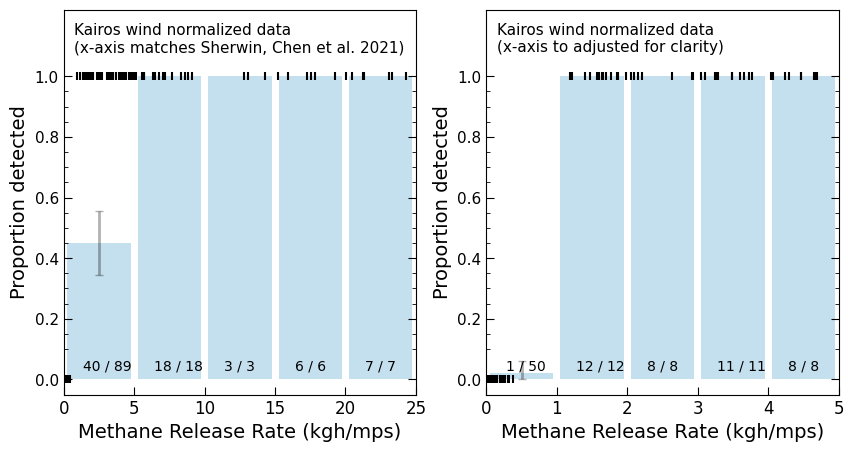

In [3]:
# Plot Kairos wind normalized lower detection limit

from methods_source import load_overpass_summary, load_operator_report_dictionary, abbreviate_op_name
from plot_methods import rand_jitter
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
import pathlib
import matplotlib.ticker as ticker



def plot_wind_normalized_MDL(ax, annotation_text, operator, stage, n_bins, threshold, strict_discard=False, time_ave=60, gas_comp_source='ms'):
    # Load overpass summary for operator, stage, and discard criteria:
    operator_df = load_overpass_summary(operator, stage, strict_discard, time_ave, gas_comp_source)

    # load Kairos' clean data report
    report_dictionary = load_operator_report_dictionary()
    operator_report = report_dictionary['kairos_1']

    operator_df['windspeed'] = operator_report['OperatorWindspeed']

    wind_normalized = []
    for index, row in operator_df.iterrows():
        if row['operator_quantification'] == 0:
            kgh_per_mps = 0
        else:
            kgh_per_mps = row['operator_quantification'] / row['windspeed']
        wind_normalized.append(kgh_per_mps)

    operator_df['operator_kgh_per_mps'] = wind_normalized

    # Apply QC filter
    # For SI: Carbon Mapper's QC for determining quantification only, and treat their detection column as applied to all points

    # if (operator == 'Carbon Mapper') or (operator == 'Scientific Aviation'):
    #     operator_df = operator_df[(operator_df.stanford_kept == 1)]
    if (operator == 'Scientific Aviation'):
        # Scientific Aviation explicitly stated that all data could be used in determining detection, their QC only
        # applied to quantification
        operator_df = operator_df[(operator_df.stanford_kept == 1)]
    else:
        operator_df = operator_df[(operator_df.qc_summary == 'pass_all')]

    # Must be non-zero values
    operator_df = operator_df.query('non_zero_release == True')

    # Select release under threshold value
    operator_df = operator_df.query('operator_kgh_per_mps <= @threshold')

    # Create bins for plot
    bins = np.linspace(0, threshold, n_bins + 1)
    detection_probability = np.zeros(n_bins)

    # These variables are for keeping track of values as I iterate through the bins in the for loop below:
    bin_size, bin_num_detected = np.zeros(n_bins).astype('int'), np.zeros(n_bins).astype('int')
    bin_median = np.zeros(n_bins)
    bin_two_sigma = np.zeros(n_bins)
    two_sigma_upper, two_sigma_lower = np.zeros(n_bins), np.zeros(n_bins)

    # For each bin, find number of data points and detection probability

    for i in range(n_bins):

        # Set boundary of bin
        bin_min = bins[i]
        bin_max = bins[i + 1]
        bin_median[i] = (bin_min + bin_max) / 2

        # Select data within the bin range
        binned_data = operator_df.loc[operator_df.operator_kgh_per_mps < bin_max].loc[
            operator_df.operator_kgh_per_mps >= bin_min]

        # Count the total number of overpasses detected within each bin
        bin_num_detected[i] = binned_data.operator_detected.sum()

        n = len(binned_data)
        bin_size[i] = n  # this is the y-value for the bin in the plot
        p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows
        detection_probability[i] = p

        # Standard Deviation of a binomial distribution
        sigma = np.sqrt(p * (1 - p) / n)
        bin_two_sigma[i] = 2 * sigma

        # Find the lower and upper bound defined by two sigma
        two_sigma_lower[i] = 2 * sigma
        two_sigma_upper[i] = 2 * sigma
        if 2 * sigma + p > 1:
            two_sigma_upper[i] = 1 - p  # probability cannot exceed 1
        if p - 2 * sigma < 0:
            two_sigma_lower[i] = p  # if error bar includes zero, set lower bound to p?

    detection_prob = pd.DataFrame({
        "bin_median": bin_median,
        "detection_prob_mean": detection_probability,
        "detection_prob_two_sigma_upper": two_sigma_upper,
        "detection_prob_two_sigma_lower": two_sigma_lower,
        "n_data_points": bin_size,
        "n_detected": bin_num_detected})

    # Function will output cm_detection and detection_prob

    detection_plot = detection_prob.copy()
    # fig, ax = plt.subplots(1, figsize=(6, 6))

    # Set bin width:
    w = threshold / n_bins / 2.5

    # Use n_bins set above
    for i in range(n_bins):
        ax.annotate(f'{detection_plot.n_detected[i]} / {detection_plot.n_data_points[i]}',
                    [detection_plot.bin_median[i] - w / 1.8, 0.03], fontsize=10)

    # for plotting purpose, we don't want a small hyphen indicating zero uncertainty interval
    detection_plot.loc[detection_plot['detection_prob_two_sigma_lower'] == 0, 'detection_prob_two_sigma_lower'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_two_sigma_upper == 0, 'detection_prob_two_sigma_upper'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_mean == 0, 'detection_prob_mean'] = np.nan

    # To avoid RuntimeWarning: All-NaN axis encountered, set yerr to None if all values are np.nan in sigma values
    # (this is the case for Carbon Mapper)

    sigma_lower = detection_plot.detection_prob_two_sigma_lower
    sigma_upper = detection_plot.detection_prob_two_sigma_upper

    if sigma_lower.isnull().all() or sigma_upper.isnull().all():
        y_error = None
    else:
        y_error = [sigma_lower, sigma_upper]

    if threshold > n_bins:
        col_width = threshold / n_bins - 0.5
    else:
        col_width = threshold / n_bins - 0.1 # 0.1 chosen because this is what looks good with 5 kgh/mps threshold

    # Plot bars and detection points
    ax.bar(detection_plot.bin_median,
           detection_plot.detection_prob_mean,
           # yerr=[detection_plot.detection_prob_two_sigma_lower, detection_plot.detection_prob_two_sigma_upper],
           yerr=y_error,
           error_kw=dict(lw=2, capsize=3, capthick=1, alpha=0.3),
           width=col_width, alpha=0.6, color='#9ecae1', ecolor='black', capsize=2)

    # yulia's color: edgecolor="black",facecolors='none'
    x_data = rand_jitter(operator_df.operator_kgh_per_mps)

    ax.scatter(x_data, np.multiply(operator_df.operator_detected, 1),
               facecolors='black',
               marker='|')


    # Axes formatting and labels
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=11)
    ax.set_xlabel('Methane Release Rate (kgh/mps)', fontsize=14)
    ax.set_ylabel('Proportion detected', fontsize=14)
    ax.tick_params(direction='in', right=True, top=True)
    ax.tick_params(labelsize=12)
    ax.minorticks_on()
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    ax.tick_params(direction='in', which='minor', length=3, bottom=False, top=False, left=True, right=True)
    ax.tick_params(direction='in', which='major', length=6, bottom=True, top=False, left=True, right=True)

    # Set axes and background color to white
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')

    # Set more room on top for annotation
    ax.set_ylim([-0.05,1.22])
    ax.set_xlim([0,threshold])
    ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
    ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=11)
    ax.annotate(annotation_text, xy=(0.03, 0.89), xycoords='axes fraction', fontsize=11)


    # plt.title(f'{operator} Probability of Detection - Stage {stage}')

    # Save figure

    if strict_discard == True:
        discard = 'strict'
    else:
        discard = 'lax'

    # now = datetime.datetime.now()
    # save_time = now.strftime("%Y%m%d")
    # op_ab = abbreviate_op_name(operator)
    # fig_name = f'detect_limit_{op_ab}_stage{stage}_{discard}_{save_time}'
    # fig_path = pathlib.PurePath('04_figures', '01_paper_figs', fig_name)
    # plt.savefig(fig_path)
    # plt.show()

    #return operator_df, detection_prob
    return ax

# kairos_df, kairos_detection = plot_wind_normalized_MDL('Kairos', 1, 5, 25, strict_discard=False, time_ave=60, gas_comp_source='ms')

stage = 1
discard = 'lax'

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[10, 5])

ax1_annotate = 'Kairos wind normalized data\n(x-axis matches Sherwin, Chen et al. 2021)'
ax2_annotate = 'Kairos wind normalized data\n(x-axis to adjusted for clarity) '
ax1 = plot_wind_normalized_MDL(ax1, ax1_annotate,  'Kairos', 1, 5, 25, strict_discard=False, time_ave=60, gas_comp_source='ms')
ax2 = plot_wind_normalized_MDL(ax2, ax2_annotate, 'Kairos', 1, 5, 5, strict_discard=False, time_ave=60, gas_comp_source='ms')
# Set minor tick marks below y=1
minor_ticks = np.arange(0.1, 1.0, 0.05)  # Minor tick positions below y=1
ax1.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
ax2.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
op_ab = abbreviate_op_name('kairos')
fig_name = f'kairos_pod_stage{stage}_{discard}_{save_time}'
fig_path = pathlib.PurePath('04_figures', '01_paper_figs', fig_name)
plt.savefig(fig_path)
plt.show()
# kairos_overpasses = load_overpass_summary(operator='Kairos', strict_discard=False, stage=1)
#
# # load Kairos' clean data report
# report_dictionary = load_operator_report_dictionary()
# operator_report = report_dictionary['kairos_1']
#
# kairos_overpasses['windspeed'] = operator_report['OperatorWindspeed']
# kairos_overpasses['operator_kgh_per_mps'] = kairos_overpasses['operator_quantification'] / kairos_overpasses['windspeed']

In [ ]:
# MethaneAIR supplemental figure with mIME and DI methods

from plot_methods import get_parity_data, make_parity_plot
import matplotlib.pyplot as plt
import datetime
import pathlib

# Kairos LS23 for all stages
mair_mime_1_data, mair_mime_1_notes = get_parity_data('MethaneAIR mIME', stage=1)
mair_di_1_data, mair_di_1_notes = get_parity_data('MethaneAIR DI', stage=1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[14, 7])

axes_max = 2300
# LS23
ax1 = make_parity_plot(mair_mime_1_data, mair_mime_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot(mair_di_1_data, mair_di_1_notes, ax2, [0, axes_max])

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'mair_separate_methods_{save_time}')
plt.savefig(save_path)
print('Figure saved')